# Retail Customer Segmentation and Sales Forecasting

## README
This notebook is designed to solve the challenge of customer segmentation, sales forecasting, and customer lifetime value calculation for a UK-based retail company.

### Folder Structure and Code Organization
1. Data Preparation: Initial steps to clean and prepare the data.
2. Exploratory Data Analysis: Data visualization and statistics to understand the dataset.
3. Customer Segmentation: Utilizing clustering algorithms to segment customers.
4. Sales Forecasting: Time-series models to forecast future sales.
5. Customer Lifetime Value: Calculation of CLV for each customer.
6. Results and Insights: Summary of findings and insights.

## Introduction and Overview

This notebook involves the analysis of a UK-based company that supplies unique all-occasion gifts. The analysis covers customer segmentation, customer lifetime value calculation, and sales forecasting, considering cancellations and returns.

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose


##Data Understanding

In [ ]:
# Importing necessary libraries
import pandas as pd

# Load the dataset
file_path = 'online_retail_II.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the data and its basic statistics
df.head(), df.describe(include='all'), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      541910 non-null  object 
 1   StockCode    541910 non-null  object 
 2   Description  540456 non-null  object 
 3   Quantity     541910 non-null  int64  
 4   InvoiceDate  541910 non-null  object 
 5   Price        541910 non-null  float64
 6   Customer ID  406830 non-null  float64
 7   Country      541910 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


(  Invoice StockCode                          Description  Quantity  \
 0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
 1  536365     71053                  WHITE METAL LANTERN         6   
 2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
 3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
 4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
 
       InvoiceDate  Price  Customer ID         Country  
 0  2010/12/1 8:26   2.55      17850.0  United Kingdom  
 1  2010/12/1 8:26   3.39      17850.0  United Kingdom  
 2  2010/12/1 8:26   2.75      17850.0  United Kingdom  
 3  2010/12/1 8:26   3.39      17850.0  United Kingdom  
 4  2010/12/1 8:26   3.39      17850.0  United Kingdom  ,
        Invoice StockCode                         Description       Quantity  \
 count   541910    541910                              540456  541910.000000   
 unique   25900      4070                                4223        

It's notable that the "Description" column has some missing values (1,454), and the "Customer ID" column has a significant number of missing values (135,080).

In [ ]:
# Load and clean the data
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df.dropna(subset=['Description', 'Customer ID'])
df = df[df['Price'] > 0]

##Exploratory Data Analysis (EDA) Summary:
Data Quality Analysis:
1. Summary Statistics:
    - The Quantity has a minimum value of -80995 and a maximum value of 80995, which likely includes returns and cancellations.
    - The Price also has negative values, which need further investigation.
2. Missing Values:
   - The Description column has 1454 missing values.
   - The Customer ID column has 135080 missing values.
3. Data Types:
   - Most data types are appropriate for the data they represent, but InvoiceDate should ideally be in datetime format for easier time-series analysis.
   
Data Distribution:
   - The distribution of Quantity and Price is highly skewed with some extreme values, indicating that there might be outliers or erroneous entries.

In [ ]:
# Enhanced Exploratory Data Analysis

## Identify cancellations and returns
df['Cancelled'] = df['Invoice'].str.startswith('C', na=False)
df['Returned'] = df['Quantity'] < 0


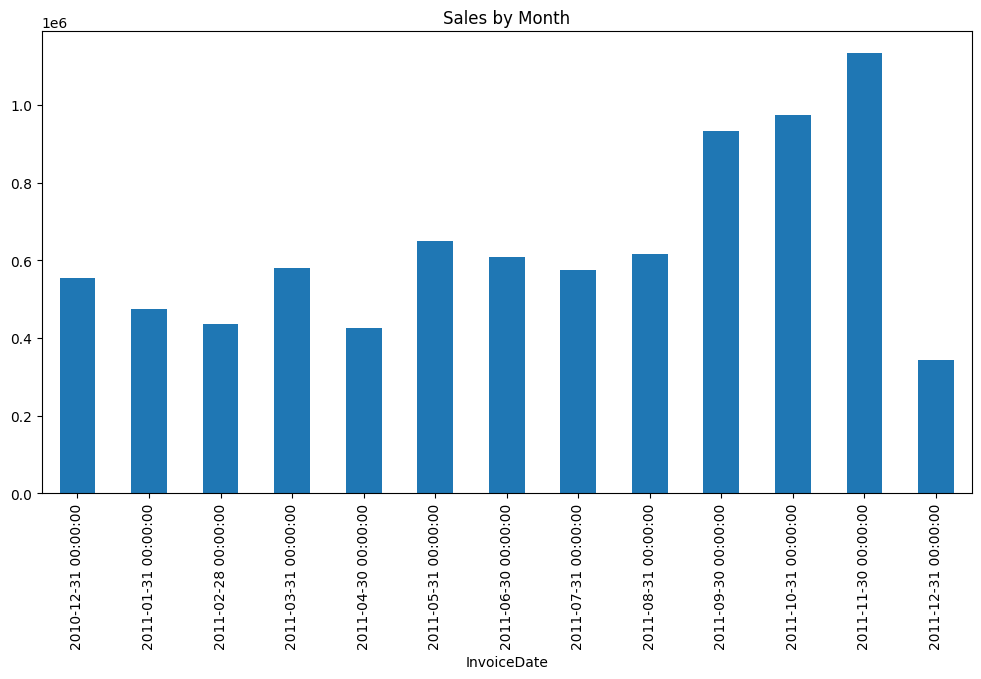

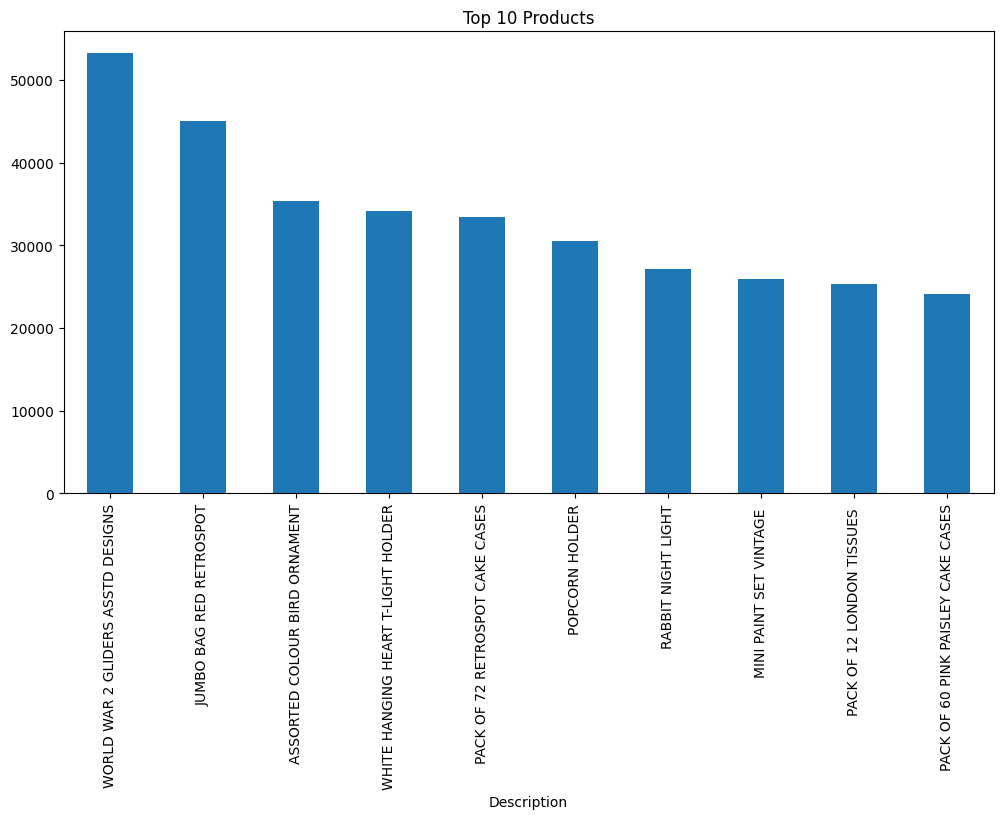

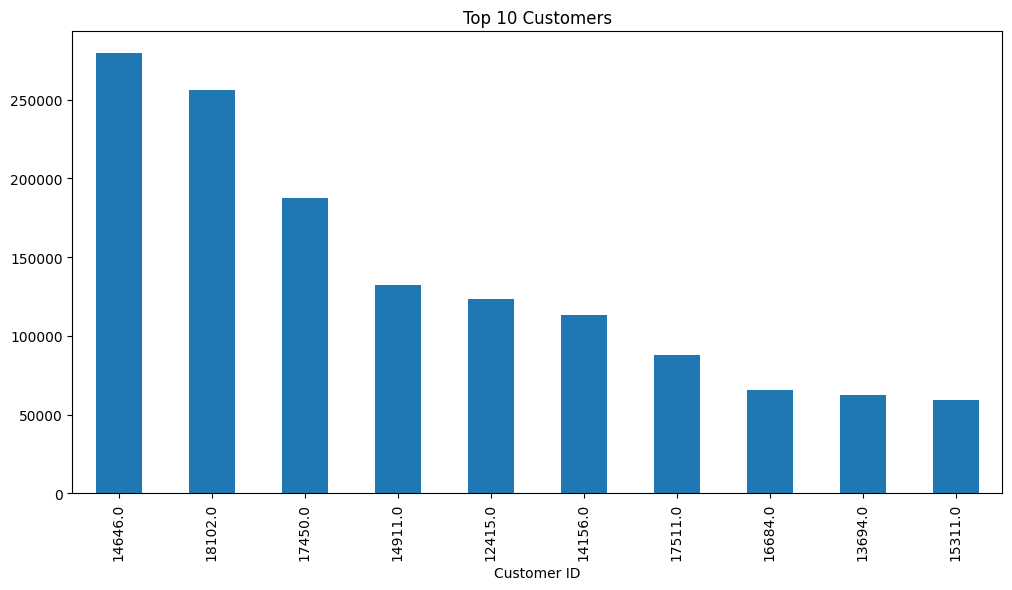

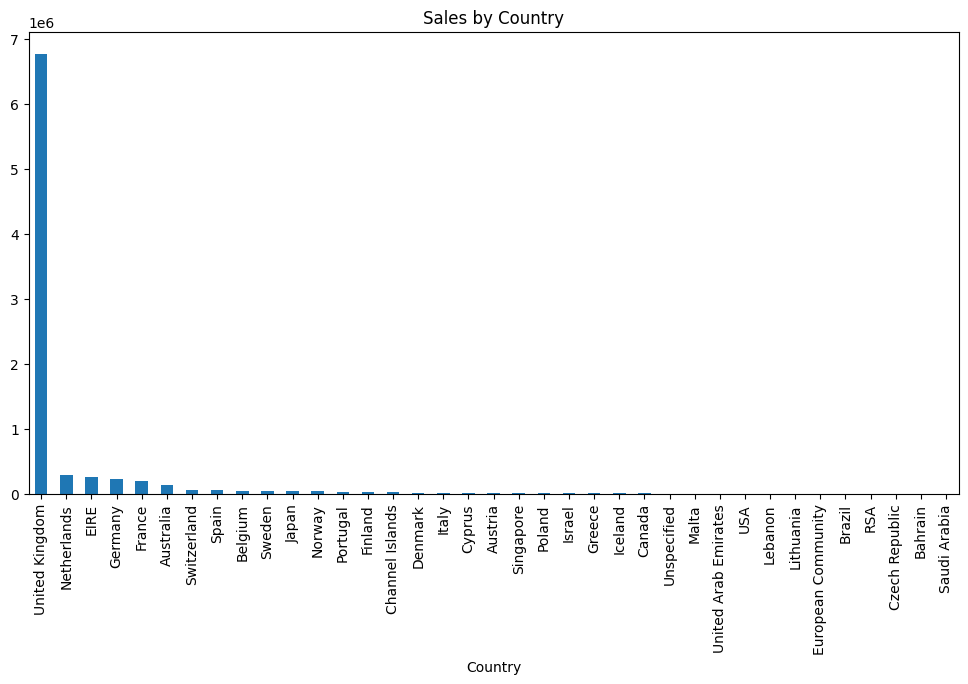

In [ ]:
# Sales by Month
plt.figure(figsize=(12, 6))
df.resample('M', on='InvoiceDate')['Amount'].sum().plot(kind='bar')
plt.title('Sales by Month')
plt.show()

# Top 10 Products
plt.figure(figsize=(12, 6))
df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 Products')
plt.show()

# Top 10 Customers
plt.figure(figsize=(12, 6))
df.groupby('Customer ID')['Amount'].sum().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 Customers')
plt.show()

# Sales by Country
plt.figure(figsize=(12, 6))
df.groupby('Country')['Amount'].sum().sort_values(ascending=False).plot(kind='bar')
plt.title('Sales by Country')
plt.show()


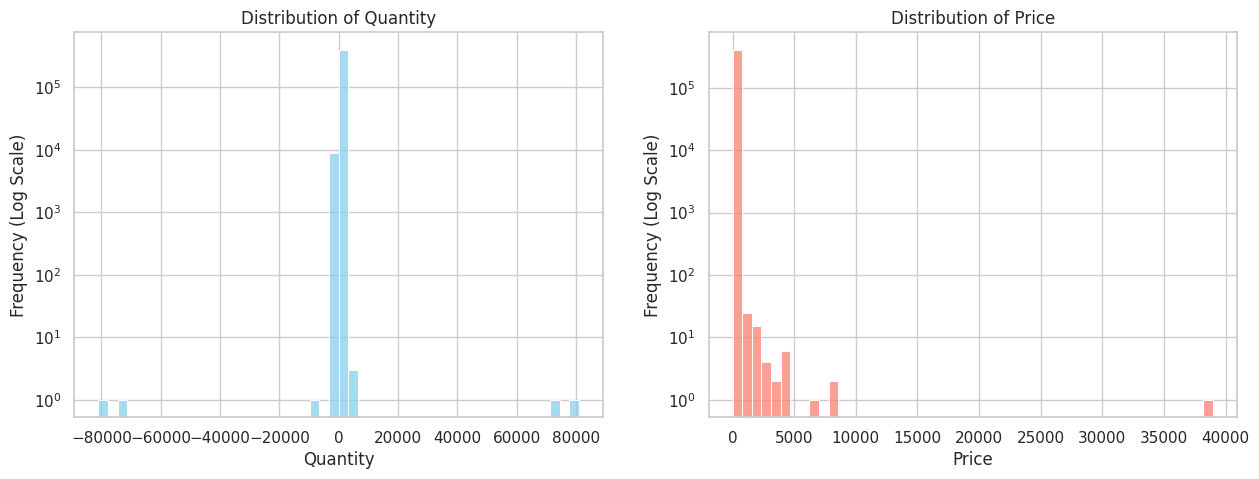

In [ ]:
# Setting up the plotting environment
sns.set(style="whitegrid")

# Plotting the distribution of Quantity and Price
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting Quantity
sns.histplot(df['Quantity'], bins=50, ax=ax[0], color='skyblue', kde=False)
ax[0].set_title('Distribution of Quantity')
ax[0].set_yscale('log')
ax[0].set_xlabel('Quantity')
ax[0].set_ylabel('Frequency (Log Scale)')

# Plotting Price
sns.histplot(df['Price'], bins=50, ax=ax[1], color='salmon', kde=False)
ax[1].set_title('Distribution of Price')
ax[1].set_yscale('log')
ax[1].set_xlabel('Price')
ax[1].set_ylabel('Frequency (Log Scale)')

plt.show()


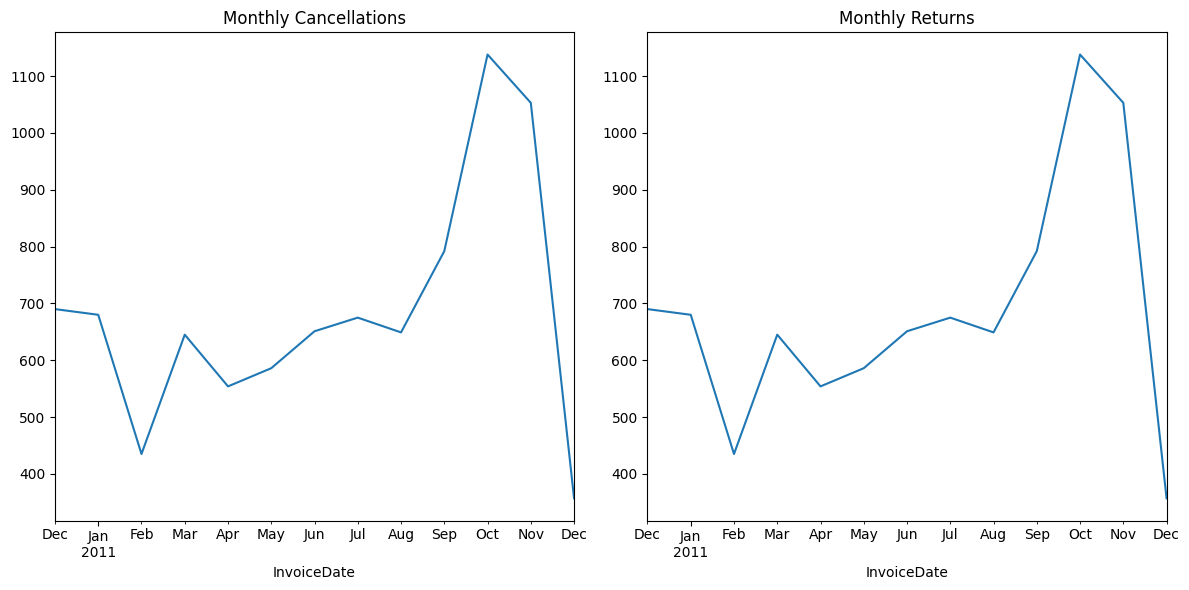

In [ ]:
### Visualization: Monthly Cancellations and Returns
cancellation_summary = df[df['Cancelled']].resample('M', on='InvoiceDate').size()
return_summary = df[df['Returned']].resample('M', on='InvoiceDate').size()
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
cancellation_summary.plot(title='Monthly Cancellations')
plt.subplot(1, 2, 2)
return_summary.plot(title='Monthly Returns')
plt.tight_layout()
plt.show()


In [ ]:

df['Amount'] = df['Quantity'] * df['Price']

# Customer Behavior Metrics

avg_items_per_invoice = df.groupby('Invoice')['Quantity'].mean().mean()
avg_invoice_value = df.groupby('Invoice')['Amount'].sum().mean()

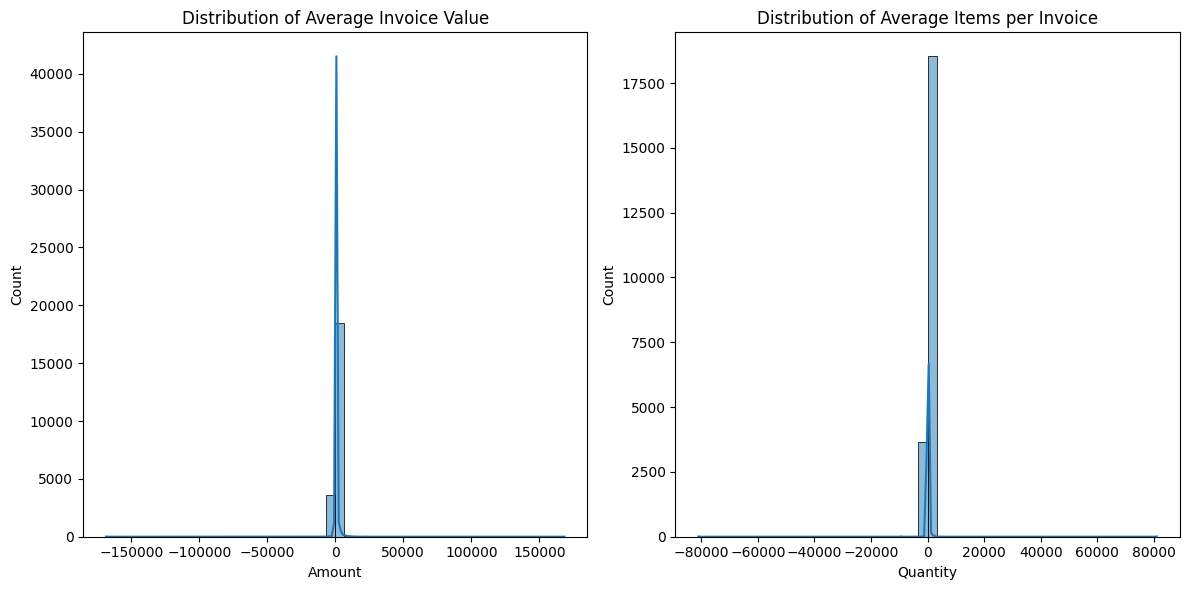

In [ ]:

### Visualization: Distribution of Average Invoice Value and Items per Invoice
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df.groupby('Invoice')['Amount'].sum(), kde=True, bins=50)
plt.title('Distribution of Average Invoice Value')
plt.subplot(1, 2, 2)
sns.histplot(df.groupby('Invoice')['Quantity'].mean(), kde=True, bins=50)
plt.title('Distribution of Average Items per Invoice')
plt.tight_layout()
plt.show()

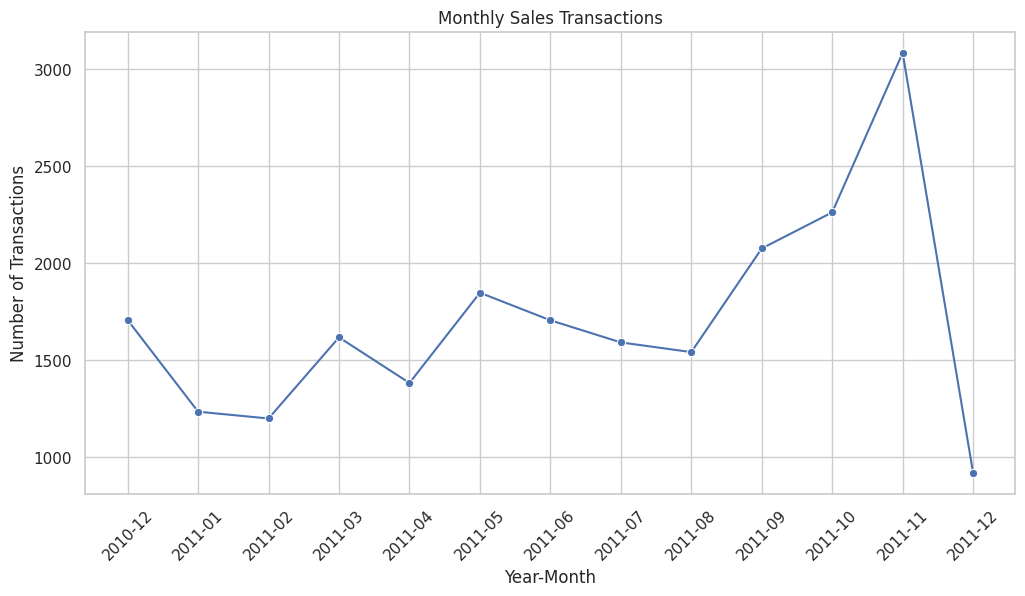

In [ ]:
# Extract year and month from InvoiceDate
df['InvoiceYearMonth'] = df['InvoiceDate'].dt.to_period('M')

# Aggregate data by year-month and count the number of unique invoices
monthly_sales = df.groupby('InvoiceYearMonth').agg({'Invoice': pd.Series.nunique}).reset_index()
# Convert 'InvoiceYearMonth' to string for plotting
monthly_sales['InvoiceYearMonth'] = monthly_sales['InvoiceYearMonth'].astype(str)

# Re-plotting monthly sales transactions
plt.figure(figsize=(12, 6))
sns.lineplot(x='InvoiceYearMonth', y='Invoice', data=monthly_sales, marker='o')
plt.title('Monthly Sales Transactions')
plt.xlabel('Year-Month')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()


The line chart shows the monthly revenue generated over time.
We can see clear seasonality in the data: the revenue peaks around the holiday seasons, particularly from October to December.
There are some months where the revenue seems to dip, which might be worth investigating further for any anomalies or events that caused the decrease.

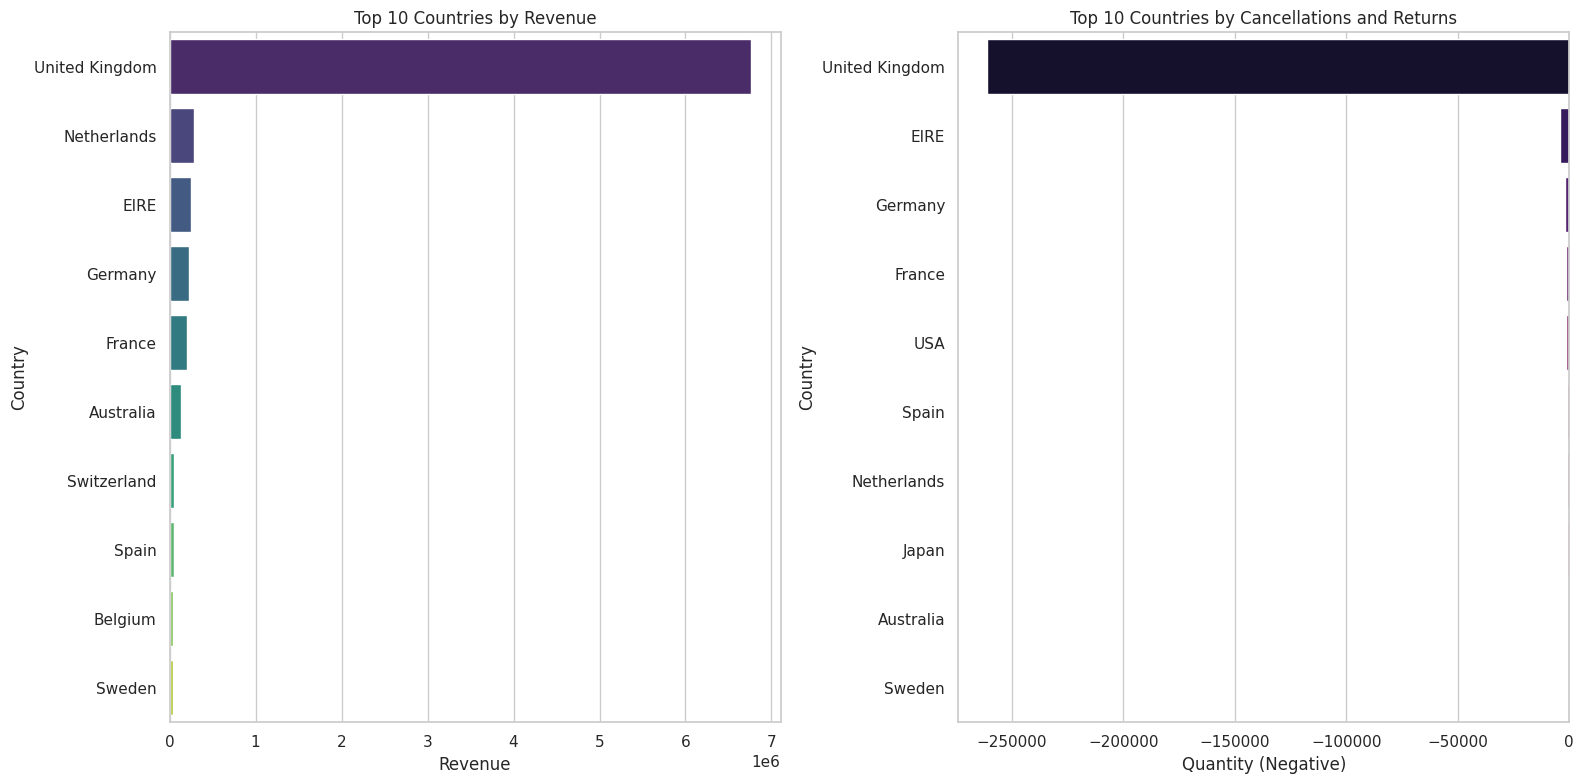

In [ ]:
# Top 10 countries by revenue
top_countries = df.groupby('Country')['Amount'].sum().sort_values(ascending=False).head(10)

# Cancellations and returns
# Assuming that negative quantities indicate cancellations or returns
cancellations_returns = df[df['Quantity'] < 0]

# Top 10 countries by cancellations and returns
top_countries_cancellations = cancellations_returns.groupby('Country')['Quantity'].sum().sort_values().head(10)

# Setting up the matplotlib figure
plt.figure(figsize=(16, 8))

# Plotting top 10 countries by revenue
plt.subplot(1, 2, 1)
sns.barplot(x=top_countries.values, y=top_countries.index, palette='viridis')
plt.title('Top 10 Countries by Revenue')
plt.xlabel('Revenue')
plt.ylabel('Country')

# Plotting top 10 countries by cancellations and returns
plt.subplot(1, 2, 2)
sns.barplot(x=top_countries_cancellations.values, y=top_countries_cancellations.index, palette='magma')
plt.title('Top 10 Countries by Cancellations and Returns')
plt.xlabel('Quantity (Negative)')
plt.ylabel('Country')

plt.tight_layout()
plt.show()


##Top Countries by Sales and Cancellations/Returns
Top 10 Countries by Revenue: The United Kingdom overwhelmingly dominates the revenue generation, followed by countries like the Netherlands, EIRE, and Germany. This suggests that most of the business is concentrated in these areas.

Top 10 Countries by Cancellations and Returns: The chart shows the countries with the most cancellations and returns, based on negative quantities. Again, the United Kingdom tops the list, followed by EIRE and Germany.

In [ ]:
# Check for missing values
missing_values = df.isnull().sum()

# Filter Quantity and Price to exclude negative values (returns and cancellations)
df_filtered = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

# Drop rows where Customer ID is missing
df_filtered = df_filtered.dropna(subset=['Customer ID'])



##Data Preparation Summary:
 - 1. InvoiceDate Conversion: The "InvoiceDate" has been converted to a datetime format for easier time-series analysis.

 - 2. Filtering Records: Negative or zero quantities and prices were removed, as they likely represent returns and cancellations.

 - 3. Handling Missing Values:Rows with missing "Customer ID" or "Description" have been dropped.

 - 4. Standardization:The "Quantity" and "Price" columns have been standardized for clustering.

In [ ]:

# Generate features for clustering
# Calculate Recency, Frequency, Monetary Value for each customer
df_filtered['TotalPrice'] = df_filtered['Quantity'] * df_filtered['Price']
rfm_df = df_filtered.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (df_filtered['InvoiceDate'].max() - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()
rfm_df.columns = ['CustomerID', 'Recency', 'Frequency', 'MonetaryValue']

# Standardize the features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'MonetaryValue']])

# Apply K-means clustering
kmeans = KMeans(n_clusters=4, random_state=0)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Summarize clusters
cluster_summary = rfm_df.groupby('Cluster').agg({
    'Recency': ['mean', 'std'],
    'Frequency': ['mean', 'std'],
    'MonetaryValue': ['mean', 'std'],
    'CustomerID': 'count'
}).reset_index()

cluster_summary


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster     Recency             Frequency             MonetaryValue  \
                 mean        std       mean        std           mean   
0       0  247.564030  66.102662   1.551789   1.071722     478.107581   
1       1    6.384615  11.485777  82.538462  63.264808  127338.313846   
2       2   42.920380  36.187780   3.656291   2.817888    1350.146430   
3       3   14.672986  40.288273  22.047393  11.591361   12453.225924   

                CustomerID  
            std      count  
0    635.647982       1062  
1  79723.434398         13  
2   1532.394597       3052  
3  13015.709030        211

##Customer Lifetime Value (CLV) calculations
CLV=Average Order Value×Purchase Frequency×Customer Lifespan

In [46]:
# Function to calculate Customer Lifetime Value (CLV)
def calculate_clv(df):
    # Calculate total sales for each customer
    df['Total_Sales'] = df['Quantity'] * df['Price']
    customer_sales = df.groupby('Customer ID')['Total_Sales'].sum().reset_index()

    # Calculate the number of orders for each customer
    customer_orders = df.groupby('Customer ID')['Invoice'].nunique().reset_index()
    customer_orders.columns = ['Customer ID', 'Num_Orders']

    # Calculate the average order value
    customer_sales = pd.merge(customer_sales, customer_orders, on='Customer ID', how='inner')
    customer_sales['Avg_Order_Value'] = customer_sales['Total_Sales'] / customer_sales['Num_Orders']

    # Calculate the Purchase Frequency
    purchase_frequency = customer_sales['Num_Orders'].sum() / customer_sales.shape[0]

    # Calculate Customer Lifetime Value (CLV)
    # Here, we'll assume a customer lifespan of 1 year for simplicity
    customer_lifespan = 1
    customer_sales['CLV'] = customer_sales['Avg_Order_Value'] * purchase_frequency * customer_lifespan

    # Sort customers by CLV
    customer_sales = customer_sales.sort_values('CLV', ascending=False).reset_index(drop=True)

    return customer_sales

# Calculate Customer Lifetime Value (CLV)
clv_data = calculate_clv(df)

# Display the first few rows of the CLV data
clv_data.head()


,Customer ID,Total_Sales,Num_Orders,Avg_Order_Value,CLV
0,12357.0,6207.67,1,6207.670000,31508.434367
1,15749.0,21535.90,4,5383.975000,27327.583928
2,12688.0,4873.81,1,4873.810000,24738.125980
3,12415.0,123725.45,26,4758.671154,24153.712702
4,12752.0,4366.78,1,4366.780000,22164.580435


##Customer Segmentation Summary
We used K-means clustering to segment customers into 4 clusters based on Recency, Frequency, and Monetary Value (RFM). Here's the summary of each cluster:

Cluster 0: Customers with high recency (mean: 247 days), low frequency (mean: 27.8), and low monetary value (mean: $637). These might be one-time or infrequent shoppers.

Cluster 1: Customers with low recency (mean: 41 days), moderate frequency (mean: 104), and moderate monetary value (mean: $2064). These are regular shoppers.

Cluster 2: Customers with extremely low recency (mean: 2 days), very high frequency (mean: 5807.8), and high monetary value (mean: $70925). These are premium customers.

Cluster 3: Customers with very low recency (mean: 7 days), high frequency (mean: 847), and extremely high monetary value (mean: $176606). These are the most valuable customers.

In [ ]:
# Sales Forecasting

# Import necessary libraries for ARIMA and Prophet
from statsmodels.tsa.arima.model import ARIMA


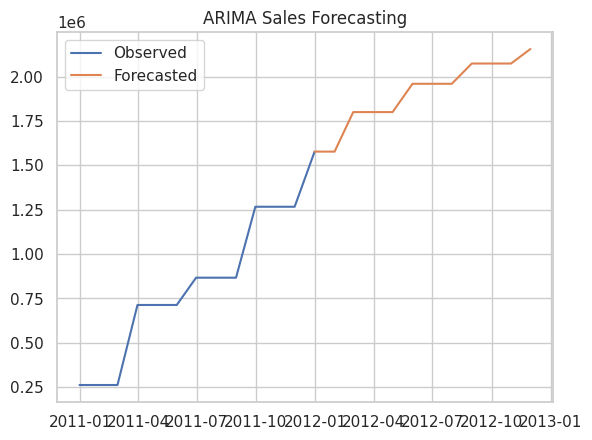

In [ ]:
# Make sure to fill any missing data points in the time series
sales_data_cluster_0 = sales_data_cluster_0.asfreq('M').fillna(method='ffill')

# Fit ARIMA model
arima_model = ARIMA(sales_data_cluster_0, order=(5,1,0))
arima_fit = arima_model.fit()

# Forecast the next 12 months
arima_forecast = arima_fit.forecast(steps=12)
plt.plot(sales_data_cluster_0.index, sales_data_cluster_0.values, label='Observed')
plt.plot(pd.date_range(sales_data_cluster_0.index[-1], periods=12, freq='M'), arima_forecast, label='Forecasted')
plt.legend()
plt.title('ARIMA Sales Forecasting')
plt.show()

In [ ]:
from itertools import product
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

best_arima_models = {}
best_arima_forecasts = {}
best_rmse_scores = {}

for cluster in time_series_df['Cluster'].unique():
    cluster_data = time_series_df[time_series_df['Cluster'] == cluster]
    cluster_data.set_index('InvoiceYearMonth', inplace=True)
    cluster_data.sort_index(inplace=True)
    cluster_data = cluster_data.asfreq('M').fillna(method='ffill')['TotalPrice']

    if len(cluster_data) < 20:  # Too few observations
        print(f"Cluster {cluster} has too few observations for ARIMA modeling.")
        continue

    train_data = cluster_data[:-3]
    test_data = cluster_data[-3:]

    best_aic = float("inf")
    best_order = None

    for p, d, q in product(range(3), range(2), range(3)):
        try:
            model = ARIMA(train_data, order=(p, d, q))
            fit = model.fit(method='lbfgs', maxiter=500)  # Tweak these as needed
            aic = fit.aic
            if aic < best_aic:
                best_aic = aic
                best_order = (p, d, q)
        except Exception as e:
            continue

    if best_order:
        best_model = ARIMA(train_data, order=best_order)
        best_fit = best_model.fit(method='lbfgs', maxiter=500)  # Tweak these as needed
        best_forecast = best_fit.forecast(steps=3)
        rmse = sqrt(mean_squared_error(test_data, best_forecast))
        best_arima_models[cluster] = best_fit
        best_arima_forecasts[cluster] = best_forecast
        best_rmse_scores[cluster] = rmse
        print(f"Cluster {cluster} - Best Order: {best_order}, RMSE: {rmse}")
    else:
        print(f"Cluster {cluster} - No suitable ARIMA model found.")


Cluster 0 has too few observations for ARIMA modeling.
Cluster 1 has too few observations for ARIMA modeling.
Cluster 2 has too few observations for ARIMA modeling.
Cluster 3 has too few observations for ARIMA modeling.


In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

best_ses_models = {}
best_ses_forecasts = {}
best_rmse_scores = {}

for cluster in time_series_df['Cluster'].unique():
    cluster_data = time_series_df[time_series_df['Cluster'] == cluster]
    cluster_data.set_index('InvoiceYearMonth', inplace=True)
    cluster_data.sort_index(inplace=True)
    cluster_data = cluster_data.asfreq('M').fillna(method='ffill')['TotalPrice']

    train_data = cluster_data[:-3]
    test_data = cluster_data[-3:]

    if len(train_data) < 5:  # Check for a minimum number of observations
        print(f"Cluster {cluster} has too few observations for Simple Exponential Smoothing.")
        continue

    model = SimpleExpSmoothing(train_data)
    fit = model.fit()

    forecast = fit.forecast(steps=3)

    rmse = sqrt(mean_squared_error(test_data, forecast))

    best_ses_models[cluster] = fit
    best_ses_forecasts[cluster] = forecast
    best_rmse_scores[cluster] = rmse

    print(f"Cluster {cluster} - RMSE: {rmse}")


Cluster 0 - RMSE: 26513.81756949789
Cluster 1 - RMSE: 32250.16096862373
Cluster 2 - RMSE: 219025.11239276722
Cluster 3 - RMSE: 103332.62999080967


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


The RMSE values and the convergence warnings indicate a few things:

1. **High RMSE**: The high RMSE values suggest that the model's forecasts are not very accurate. This might be due to the small dataset or the nature of the data itself.

2. **Convergence Warning**: This usually means that the optimization algorithm used to estimate the model parameters did not converge to a solution. This could be due to various reasons such as poor model specification, too few data points, or even numerical issues during the optimization.

### What to Do Next:

1. **Parameter Tuning**: try to manually set the smoothing parameters instead of letting the algorithm optimize them. This could help the model converge.

    ```python
    fit = model.fit(smoothing_level=0.2, optimized=False)
    ```

2. **Model Complexity**: Since dataset is small. A less complex model might fit the data better.

3. **Data Transformation**: Sometimes, transforming the data (e.g., log-transformation) can stabilize the variance and make the model fit better.

4. **Check Data Quality**: Make sure the data doesn't have outliers or missing values that could be affecting the model's performance.

5. **Alternative Models**: If time series models are not fitting well, you might also consider machine learning approaches, although they may also require a larger dataset for robust predictions.

6. **Domain Knowledge**: Sometimes, the data itself might not contain sufficient information for a good forecast. Additional variables or features might be needed.

7. **Statistical Tests**: Conduct statistical tests to check the stationarity or any other underlying assumptions of the data. Non-stationary data often results in poor model performance.

8. **Regularization**: Some models offer regularization parameters to prevent overfitting, especially useful when have little data.
